In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm

In [102]:
# Selecting 10 diversified S&P 500 tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'JPM', 'UNH', 'XOM', 'PG']

# Downloading adjusted historical prices
# auto_adjust=True makes 'Close' equal to 'Adj Close' by adjusting for splits/dividends
data = yf.download(tickers, start='2015-01-01', end='2025-01-01', auto_adjust=True)['Close']

# Preview the data
data.head()


[*********************100%***********************]  10 of 10 completed


Ticker,AAPL,AMZN,GOOGL,JPM,META,MSFT,NVDA,PG,UNH,XOM
Date,,,,,,,,,,
2015-01-02,24.320431,15.4260,26.351515,47.174263,78.082001,40.072136,0.483099,67.441559,86.192581,59.510227
2015-01-05,23.635284,15.1095,25.849415,45.709736,76.827911,39.703625,0.474939,67.120918,84.772858,57.881912
2015-01-06,23.637520,14.7645,25.211466,44.524529,75.792801,39.120888,0.460540,66.815186,84.601814,57.574211
2015-01-07,23.968964,14.9210,25.137320,44.592472,75.792801,39.617943,0.459340,67.165680,85.465630,58.157578
2015-01-08,24.889904,15.0230,25.224903,45.588959,77.813271,40.783413,0.476619,67.933731,89.545204,59.125618


In [104]:
# Calculating simple daily percentage returns
returns = data.pct_change().dropna()
returns.head()

Ticker,AAPL,AMZN,GOOGL,JPM,META,MSFT,NVDA,PG,UNH,XOM
Date,,,,,,,,,,
2015-01-05,-0.028172,-0.020517,-0.019054,-0.031045,-0.016061,-0.009196,-0.016890,-0.004754,-0.016472,-0.027362
2015-01-06,0.000095,-0.022833,-0.024679,-0.025929,-0.013473,-0.014677,-0.030318,-0.004555,-0.002018,-0.005316
2015-01-07,0.014022,0.010600,-0.002941,0.001526,0.000000,0.012706,-0.002605,0.005246,0.010210,0.010132
2015-01-08,0.038422,0.006836,0.003484,0.022347,0.026658,0.029418,0.037617,0.011435,0.047734,0.016645
2015-01-09,0.001072,-0.011749,-0.012211,-0.017387,-0.005628,-0.008405,0.004028,-0.009330,-0.009360,-0.001410


In [106]:
# Calculating trailing 12-month returns (~252 trading days)
momentum_scores = data.pct_change(252)

# Resampling to monthly frequency for rebalancing
momentum_monthly = momentum_scores.resample('M').last()

# Generating signals: long top 3 stocks each month based on 1-year return
def generate_momentum_signals(momentum_df, top_n=3):
    signals = pd.DataFrame(index=momentum_df.index, columns=momentum_df.columns)
    for date in momentum_df.index:
        top_stocks = momentum_df.loc[date].nlargest(top_n).index
        signals.loc[date, top_stocks] = 1
    return signals.reindex_like(momentum_df).fillna(0)

momentum_signals = generate_momentum_signals(momentum_monthly)

/var/folders/lm/pdklyj6n0hdcrq939jw53_880000gn/T/ipykernel_55187/2279756823.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  momentum_monthly = momentum_scores.resample('M').last()
/var/folders/lm/pdklyj6n0hdcrq939jw53_880000gn/T/ipykernel_55187/2279756823.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return signals.reindex_like(momentum_df).fillna(0)


In [108]:
# Resampling adjusted prices to weekly frequency (every Friday)
weekly_prices = data.resample('W-FRI').last()

# Calculating 1-week returns from weekly prices
weekly_returns = weekly_prices.pct_change()

# Generating signals: long bottom 3 stocks each week based on worst 1-week return
def generate_mean_reversion_signals(returns_df, bottom_n=3):
    signals = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)
    for date in returns_df.index:
        bottom_stocks = returns_df.loc[date].nsmallest(bottom_n).index
        signals.loc[date, bottom_stocks] = 1
    return signals.reindex_like(returns_df).fillna(0)

mean_reversion_signals = generate_mean_reversion_signals(weekly_returns)

/var/folders/lm/pdklyj6n0hdcrq939jw53_880000gn/T/ipykernel_55187/4230214522.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return signals.reindex_like(returns_df).fillna(0)


In [110]:
# Expanding signals to daily frequency so they align with daily returns
momentum_signals_filled = momentum_signals.reindex(returns.index).ffill()
mean_reversion_signals_filled = mean_reversion_signals.reindex(returns.index).ffill()

# Shifting signals by 1 day to avoid look-ahead bias
momentum_positions = momentum_signals_filled.shift(1)
mean_reversion_positions = mean_reversion_signals_filled.shift(1)

In [112]:
# Calculating strategy returns by averaging returns of selected stocks
momentum_portfolio_returns = (momentum_positions * returns).mean(axis=1)
mean_reversion_portfolio_returns = (mean_reversion_positions * returns).mean(axis=1)

# Dropping initial NaNs
momentum_portfolio_returns = momentum_portfolio_returns.dropna()
mean_reversion_portfolio_returns = mean_reversion_portfolio_returns.dropna()

# Preview
momentum_portfolio_returns.head(), mean_reversion_portfolio_returns.head()

(Date
 2015-04-01   -0.001578
 2015-04-02   -0.000090
 2015-04-06    0.003394
 2015-04-07   -0.001582
 2015-04-08    0.002219
 dtype: float64,
 Date
 2015-01-12   -0.003449
 2015-01-13    0.002113
 2015-01-14   -0.003126
 2015-01-15   -0.005738
 2015-01-16    0.004310
 dtype: float64)

In [114]:
# Calculating cumulative portfolio value
momentum_cumulative = (1 + momentum_portfolio_returns).cumprod()
mean_reversion_cumulative = (1 + mean_reversion_portfolio_returns).cumprod()

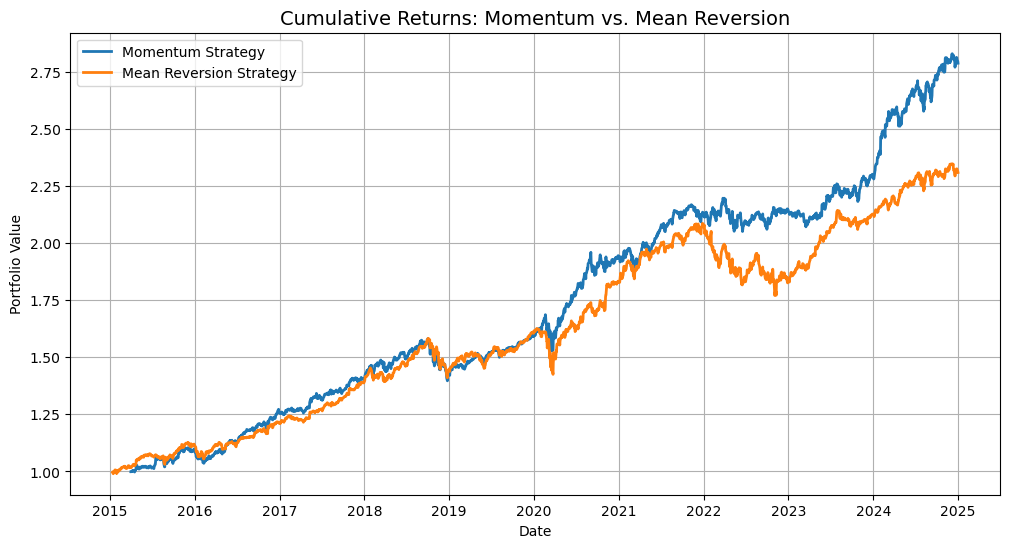

In [116]:
# Plotting both cumulative returns on the same chart
plt.figure(figsize=(12,6))
plt.plot(momentum_cumulative, label='Momentum Strategy', linewidth=2)
plt.plot(mean_reversion_cumulative, label='Mean Reversion Strategy', linewidth=2)
plt.title('Cumulative Returns: Momentum vs. Mean Reversion', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()